# STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


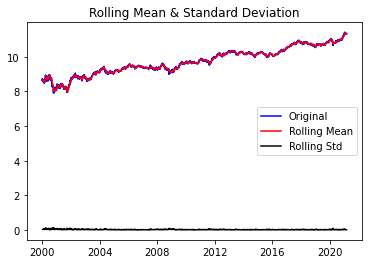

Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


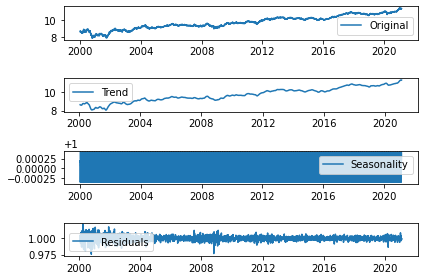

In [6]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)


from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성

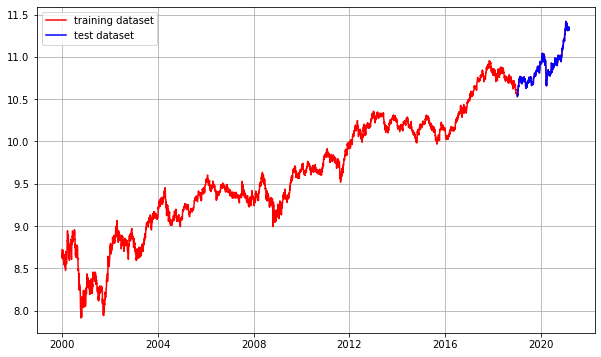

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

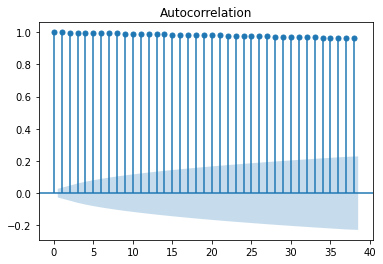

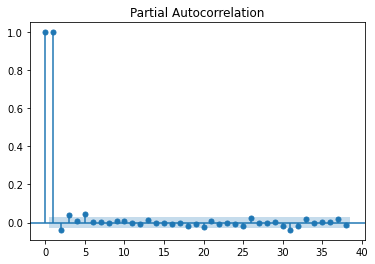

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.841431
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


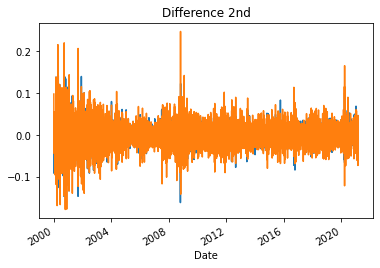

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# STEP 6 : ARIMA 모델 훈련과 테스트

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4787
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11282.237
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 04 Mar 2021   AIC                         -22558.473
Time:                        09:50:50   BIC                         -22539.052
Sample:                             1   HQIC                        -22551.651
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.093      0.275      -0.000       0.001
ar.L1.D.Close     0.0436      0.014      3.017      0.003       0.015       0.072
                                    Root

/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

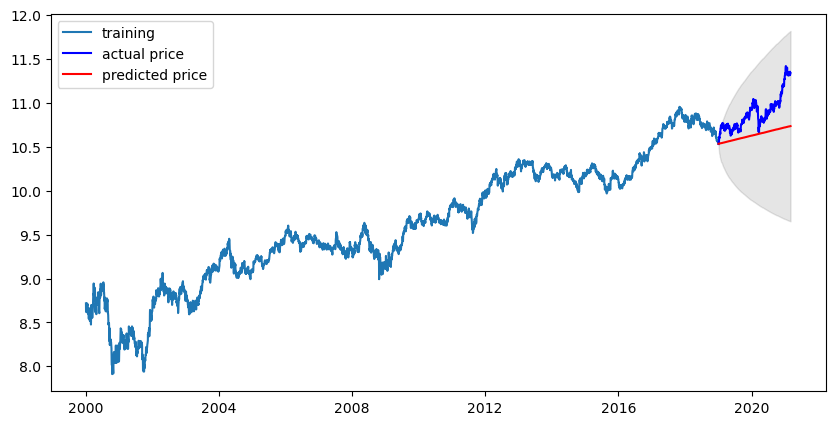

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  255620791.69096795
MAE:  12827.412931415869
RMSE:  15988.145348694074
MAPE: 21.45%


d값은 내버려두고 p,q만 바꿔봤을때 아무리 MAPE가 낮아져도 20%였다. p 혹은 q가 10이 넘어가면 모델 훈련에 시간이 엄청 걸리던데 어떤 기준으로 해야할지 고민이다.

# 델타항공

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DAL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2007-05-03    20.719999
2007-05-04    20.980000
2007-05-07    20.360001
2007-05-08    19.629999
2007-05-09    19.790001
Name: Close, dtype: float64

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
ts_log = np.log(ts)

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


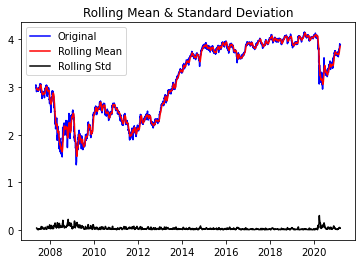

Results of Dickey-Fuller Test:
Test Statistic                   -0.998334
p-value                           0.753871
#Lags Used                       30.000000
Number of Observations Used    3452.000000
Critical Value (1%)              -3.432246
Critical Value (5%)              -2.862378
Critical Value (10%)             -2.567216
dtype: float64


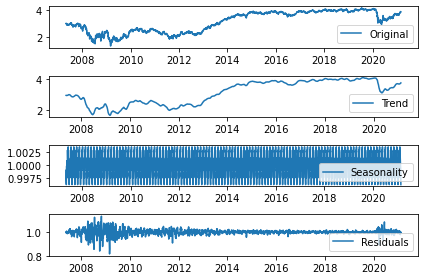

In [6]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)


from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.504196e+01
p-value                        9.564254e-28
#Lags Used                     2.800000e+01
Number of Observations Used    3.424000e+03
Critical Value (1%)           -3.432261e+00
Critical Value (5%)           -2.862384e+00
Critical Value (10%)          -2.567220e+00
dtype: float64


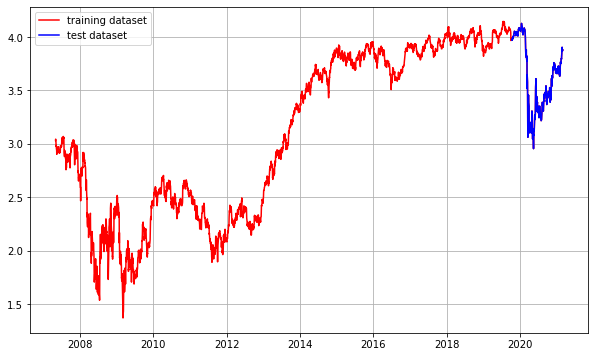

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

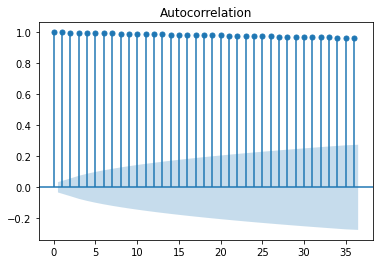

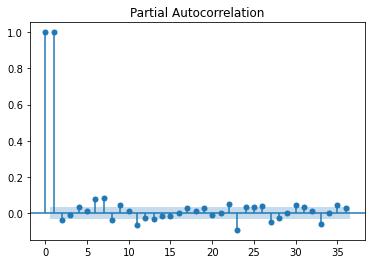

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.134647e+01
p-value                        1.024177e-20
#Lags Used                     2.900000e+01
Number of Observations Used    3.452000e+03
Critical Value (1%)           -3.432246e+00
Critical Value (5%)           -2.862378e+00
Critical Value (10%)          -2.567216e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.800116e+01
p-value                        2.733969e-30
#Lags Used                     3.000000e+01
Number of Observations Used    3.450000e+03
Critical Value (1%)           -3.432247e+00
Critical Value (5%)           -2.862378e+00
Critical Value (10%)          -2.567216e+00
dtype: float64


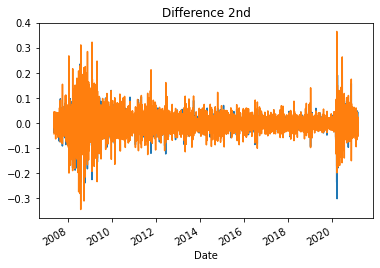

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6241.403
Method:                       css-mle   S.D. of innovations              0.033
Date:                Thu, 04 Mar 2021   AIC                         -12476.806
Time:                        19:41:30   BIC                         -12458.656
Sample:                             1   HQIC                        -12470.292
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.504      0.615      -0.001       0.001
ar.L1.D.Close     0.0086      0.018      0.482      0.630      -0.026       0.044
                                    Root

/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

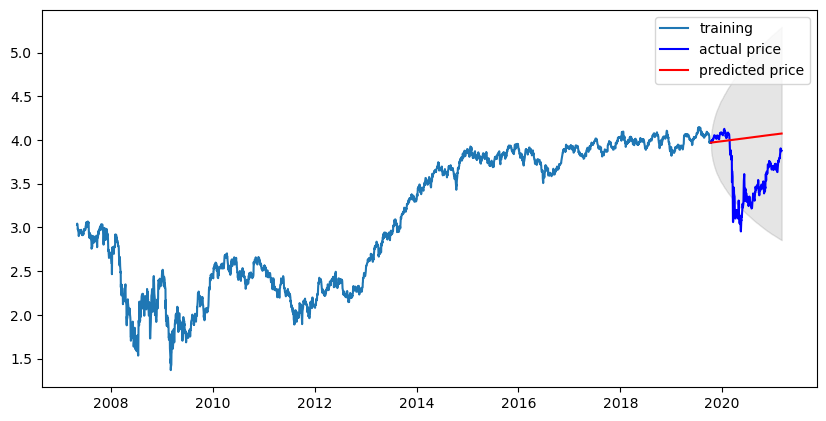

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  455.8907385305742
MAE:  18.481234873646315
RMSE:  21.351598032245132
MAPE: 61.58%


# 델타항공 기간 조정1

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DAL2.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2014-01-06    29.290001
2014-01-07    28.780001
2014-01-08    29.799999
2014-01-09    31.059999
2014-01-10    31.469999
Name: Close, dtype: float64

In [15]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [16]:
ts_log = np.log(ts)

In [17]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [18]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


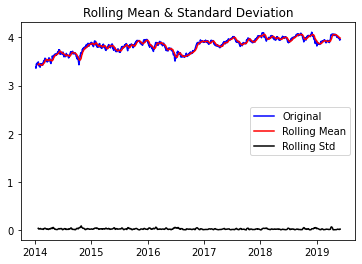

Results of Dickey-Fuller Test:
Test Statistic                   -3.184628
p-value                           0.020892
#Lags Used                        0.000000
Number of Observations Used    1360.000000
Critical Value (1%)              -3.435167
Critical Value (5%)              -2.863668
Critical Value (10%)             -2.567903
dtype: float64


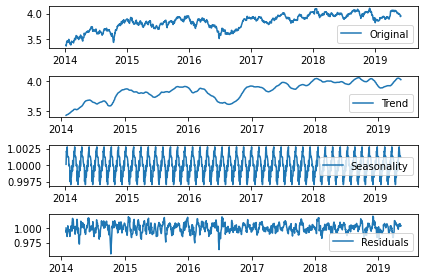

In [19]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)


from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.007941e+01
p-value                        1.199594e-17
#Lags Used                     2.000000e+01
Number of Observations Used    1.310000e+03
Critical Value (1%)           -3.435352e+00
Critical Value (5%)           -2.863749e+00
Critical Value (10%)          -2.567946e+00
dtype: float64


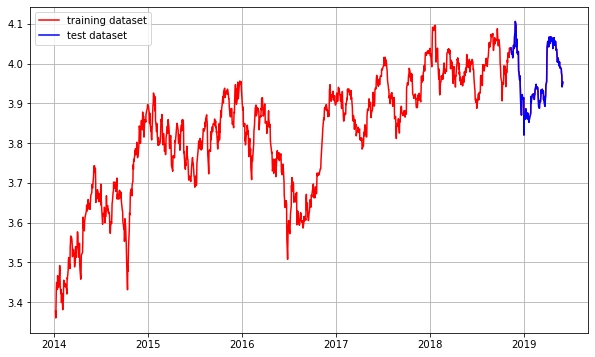

In [21]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

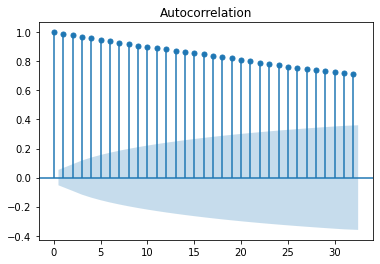

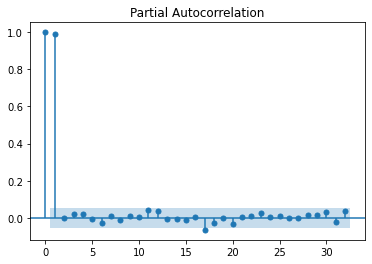

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -37.557971
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1359.000000
Critical Value (1%)              -3.435171
Critical Value (5%)              -2.863669
Critical Value (10%)             -2.567904
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.520287e+01
p-value                        5.796739e-28
#Lags Used                     1.800000e+01
Number of Observations Used    1.340000e+03
Critical Value (1%)           -3.435239e+00
Critical Value (5%)           -2.863699e+00
Critical Value (10%)          -2.567920e+00
dtype: float64


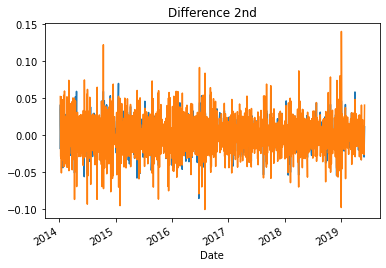

In [23]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [36]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(16, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1223
Model:                ARIMA(16, 1, 0)   Log Likelihood                3137.079
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                          -6238.157
Time:                        19:47:20   BIC                          -6146.194
Sample:                             1   HQIC                         -6203.548
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0005      0.000      1.158      0.247      -0.000       0.001
ar.L1.D.Close     -0.0111      0.029     -0.388      0.698      -0.067       0.045
ar.L2.D.Close     -0.0297      0.029

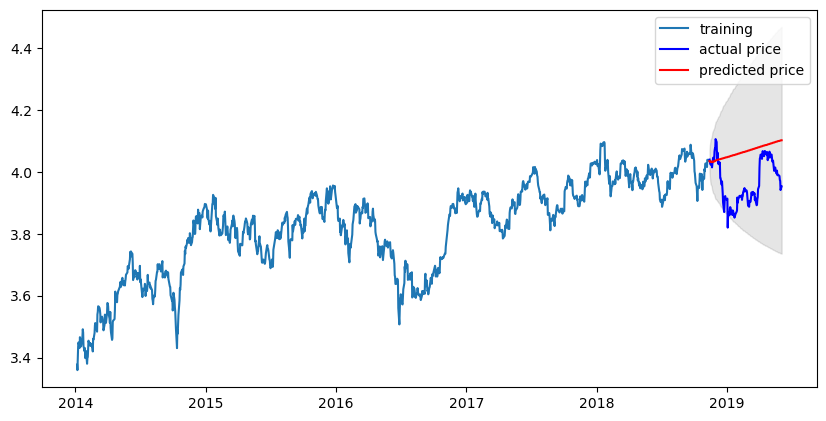

In [37]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  42.82215861415333
MAE:  5.6628229514817
RMSE:  6.543864195882532
MAPE: 11.15%


# 델타항공 기간 조정2

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DAL3.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2014-01-06    29.290001
2014-01-07    28.780001
2014-01-08    29.799999
2014-01-09    31.059999
2014-01-10    31.469999
Name: Close, dtype: float64

In [40]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [41]:
ts_log = np.log(ts)

In [42]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [43]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


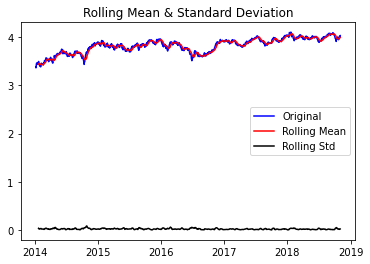

Results of Dickey-Fuller Test:
Test Statistic                   -2.916382
p-value                           0.043476
#Lags Used                        0.000000
Number of Observations Used    1217.000000
Critical Value (1%)              -3.435735
Critical Value (5%)              -2.863918
Critical Value (10%)             -2.568036
dtype: float64


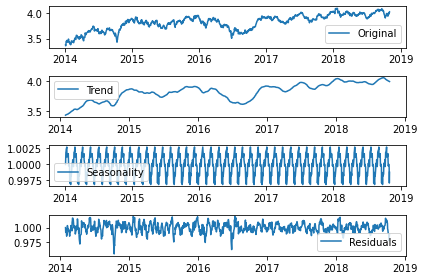

In [44]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)


from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.844604e+00
p-value                        4.655559e-17
#Lags Used                     1.800000e+01
Number of Observations Used    1.169000e+03
Critical Value (1%)           -3.435956e+00
Critical Value (5%)           -2.864016e+00
Critical Value (10%)          -2.568088e+00
dtype: float64


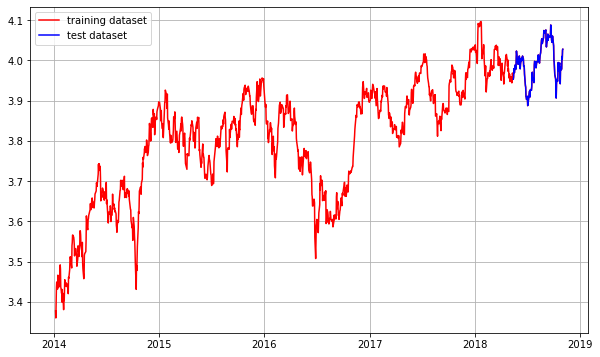

In [46]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

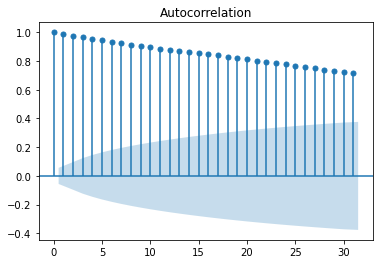

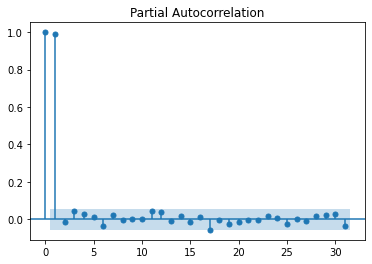

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -35.111608
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1216.000000
Critical Value (1%)              -3.435739
Critical Value (5%)              -2.863920
Critical Value (10%)             -2.568037
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.249716e+01
p-value                        2.859261e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.193000e+03
Critical Value (1%)           -3.435843e+00
Critical Value (5%)           -2.863966e+00
Critical Value (10%)          -2.568061e+00
dtype: float64


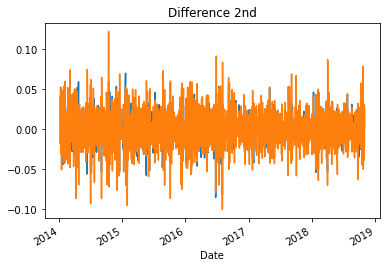

In [48]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [49]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1095
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2782.023
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                          -5558.046
Time:                        19:51:23   BIC                          -5543.051
Sample:                             1   HQIC                         -5552.372
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.001      0.943      0.346      -0.001       0.002
ar.L1.D.Close    -0.0066      0.030     -0.218      0.827      -0.066       0.053
                                    Root

/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj43/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

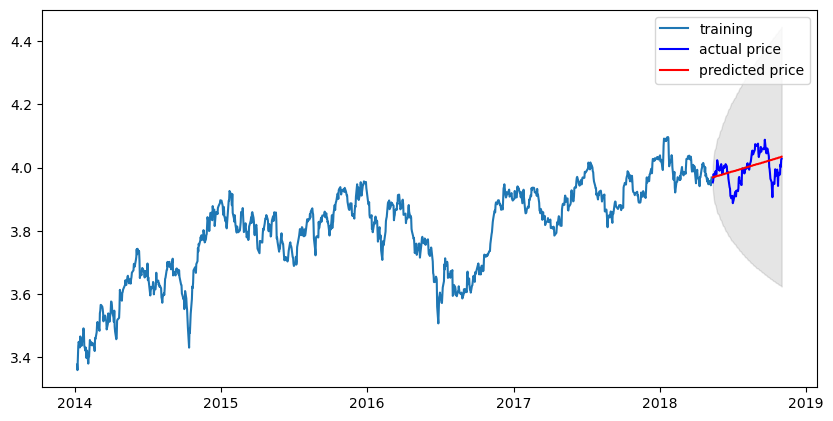

In [50]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6.0299046167131065
MAE:  2.014578338575582
RMSE:  2.45558640994633
MAPE: 3.76%


# 회고

삼성전자 데이터 기간을 MAX로 해두고 p,d,q값을 이리저리 바꿔보면서 MAPE 값을 낮춰보려고 노력했다. d값을 2로 두면 그래프가 완전히 평탄해져서 d값은 1로 두고 p, q값을 조정했다.  

학습 노드에서 p*q=0으로 하는 것을 권장한다고해서 반드시 그래야하는지 알았는데 특정값에서는 p와q값 중 하나가 0이 아니여도 모델 학습이 가능했다.  

p를 높이거나 q를 높이거나 둘 중에 하나를 선택했는데 8을 초과하면 학습에 걸리는 시간이 엄청 오래걸렸다. 50까지 해봤는데 학습에는 오래 걸리고 결과값은 거의 차이가 없어 더이상 시도하지 않았다.  

그러던 중 삼성전자 데이터로 MAPE 5%를 만들었다는 분이 있어 확인해봤더니 데이터 기준 기간이 달랐다. 그래프 시각화한 분을 보니 그래프가 비교적 수렴을 잘하고 있었다. 평탄한 그래프를 선택해서 그런건가 의문이 들었다. 특히 영준님께서 이게 어느 데이터에나 정확하게 나온다면 주식 시장 예측이 너무 쉬워지지 않겠냐고한 말을 듣고 ARIMA 모델이 잘 적용되는 데이터가 따로 있을거라는 생각을 하게됐다. 즉, 모수를 변경해서 MAPE값을 낮추는데는 한계가 있을거고 비교적 평탄한 데이터를 찾으면 MAPE값을 낮게 만들 수 있을거라 생각했다.

그래서 동일한 델타 항공 주가를 기간을 나눠서 확인해봤다.  

주가가 평탄하게 수렴하는 데이터에 ARIMA를 적용하면 MAPE값이 낮게 나타났다.  

모수를 바꿈으로써 몇 퍼센트 정도의 차이는 만들수 있겠지만 10-20% 정도의 차이를 만들어내진 못할거라는 나름의 결론이 생겼다. 단지, ARIMA 모델에 적합한 데이터에 대해서만 ARIMA 모델을 사용해야 하는 것이 아닐까라는 생각을 하게됐다.